<a href="https://colab.research.google.com/github/O-Kpy/Project/blob/main/%E1%84%80%E1%85%B5%E1%84%89%E1%85%A1%E1%86%BC%E1%84%83%E1%85%A6%E1%84%8B%E1%85%B5%E1%84%90%E1%85%A5(%E1%84%91%E1%85%A9%E1%86%A8%E1%84%8B%E1%85%A7%E1%86%B7)_%EB%8D%B0%EC%9D%B4%ED%84%B0%EB%B6%84%EC%84%9D(project2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy import stats
import os

In [1]:
!apt-get update -qq  ## 나눔 설치
!apt-get install fonts-nanum* -qq

Selecting previously unselected package fonts-nanum.
(Reading database ... 160837 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-6_all.deb ...
Unpacking fonts-nanum-eco (1.000-6) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20170925-1_all.deb ...
Unpacking fonts-nanum-extra (20170925-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-1_all.deb ...
Unpacking fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-extra (20170925-1) ...
Setting up fonts-nanum (20170925-1) ...
Setting up fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-eco (1.000-6) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...


In [2]:
import matplotlib as mpl
import matplotlib.font_manager as fm   ## 폰트 매니저
fontpath = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf' 
font = fm.FontProperties(fname=fontpath, size=9).get_name()
plt.rc('font', family=font) 
mpl.font_manager._rebuild()

# Read Me

---

- 개 더운 여름(2021-07-27)에 폭염 때문에 빡친 나는 언제까지 폭염이 닥칠 것인가에 대한 데이터 분석을 시작한다.

- 데이터 셋은 기상청기상자료개방포털(https://data.kma.go.kr/cmmn/main.do)에서 가져 왔다.

- 데이터는 [일시, 지점, 폭염여부(O/X), 최고체감온도(°C), 최고기온(°C), 평균기온(°C), 최저기온(°C), 평균상대습도(%), 폭염특보(O/X), 폭염영향예보(단계), 열대야(O/X), 자외선지수(단계)]의 테이블로 구성되어 있다.

- 데이터의 기간[일시]는 **2019-05 ~ 2021-07**까지 수집 되었다.

- 53946 rows 구성의 데이터이다.

- 각 컬럼에 NaN값도 존재한다. ==> 그 지역, 그 시기 값의 평균or중위수로 치환

- 데이터[폭염영향예보(단계)] = ' ', '관심', '주의', '경고', '심각'으로 구성
 - ' '는 폭염과 관련 없는 날씨를 의미 하기 때문에 '평시'로 replace

In [43]:
data = pd.read_excel('/content/drive/MyDrive/dataset/공공데이터/폭염데이터-기상청/기상데이터(폭염).xlsx')
data = data.sort_values('일시')

In [44]:
data['일시'] = pd.to_datetime(data['일시'], format='%Y-%m-%d')

data['year'] = data['일시'].dt.year
data['month'] = data['일시'].dt.month
data['day'] = data['일시'].dt.day
data['date'] = data['일시'].dt.date

In [45]:
# 지역명 전처리(깔끔)
data['지점'] = data['지점'].apply(lambda x: x.split('(')[0])

Text(0, 0.5, '')

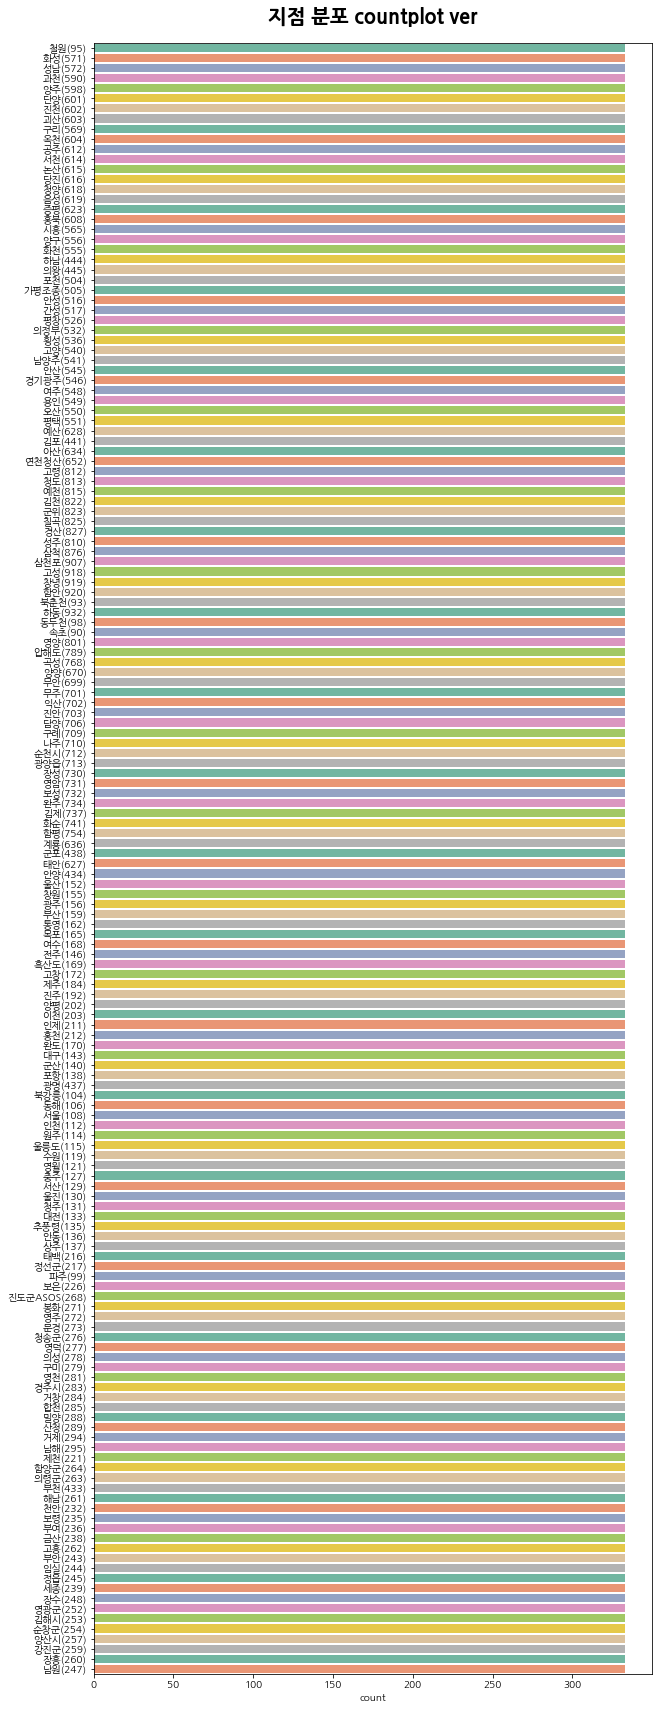

In [6]:
plt.figure(figsize=(10,30))
sns.countplot(y=data['지점'], palette=sns.color_palette('Set2', n_colors=data['지점'].nunique()))
plt.title('지점 분포 countplot ver', fontsize=20, pad=20, fontweight='bold')
plt.ylabel('')

누락된 날짜, 지점은 없는 것으로 해석

---

# 누락 값 처리(Feature Engineering)

In [102]:
# 각 컬럼의 NaN 나타내는 테이블(table)-야매ver
data_isnull = data.isnull().sum().reset_index(name='count')
data_nullmean = data.isnull().mean().reset_index(name='percent')

data_isnull_table = data_isnull.merge(data_nullmean, how='left', on='index').set_index('index').sort_values('percent', ascending=False)
data_isnull_table

,count,percent
index,,
일시,0,0.0
지점,0,0.0
폭염여부(O/X),0,0.0
최고체감온도(°C),0,0.0
최고기온(°C),0,0.0
평균기온(°C),0,0.0
최저기온(°C),0,0.0
평균상대습도(%),0,0.0
폭염특보(O/X),0,0.0


In [47]:
# NaN값들을 지점 별로 value_counts(), unstack()한 table ==> 시각화 하기 위해서
# 각 값들은 NaN값의 개수를 나타낸 것

humid = data.groupby('지점')['평균상대습도(%)'].value_counts(dropna=False).unstack().fillna(0).iloc[:,0].reset_index(name='평균상대습도(%)')
sensory = data.groupby('지점')['최고체감온도(°C)'].value_counts(dropna=False).unstack().fillna(0).iloc[:,0].reset_index(name='최고체감온도(°C)')
low = data.groupby('지점')['최저기온(°C)'].value_counts(dropna=False).unstack().fillna(0).iloc[:,0].reset_index(name='최저기온(°C)')
high = data.groupby('지점')['최고기온(°C)'].value_counts(dropna=False).unstack().fillna(0).iloc[:,0].reset_index(name='최고기온(°C)')
mean = data.groupby('지점')['평균기온(°C)'].value_counts(dropna=False).unstack().fillna(0).iloc[:,0].reset_index(name='평균기온(°C)')

null_table = humid.merge(sensory, how='left', on='지점').merge(low, how='left', on='지점').merge(high, how='left', on='지점').merge(mean, how='left', on='지점').set_index('지점')

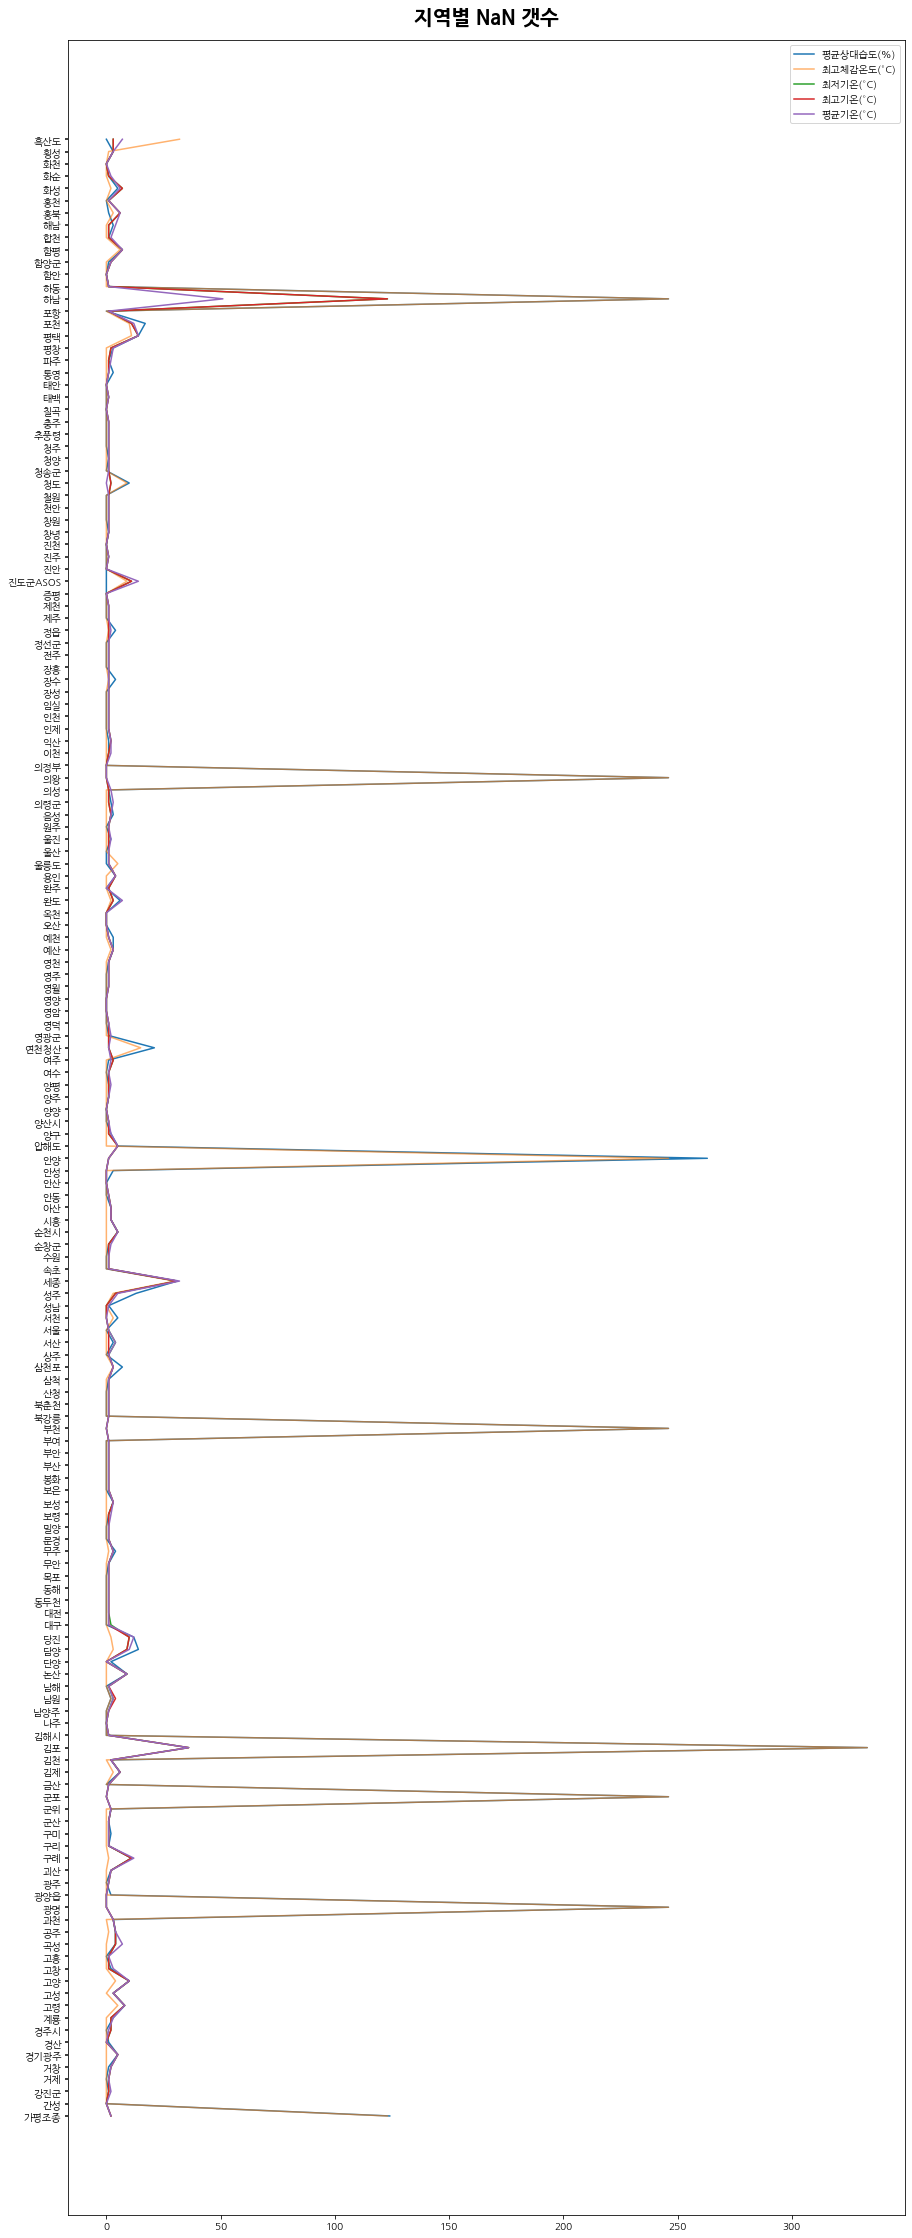

In [48]:
plt.figure(figsize=(15,40))
plt.plot(null_table['평균상대습도(%)'], null_table.index, label='평균상대습도(%)')
plt.plot(null_table['최고체감온도(°C)'], null_table.index, label='최고체감온도(°C)', alpha=0.6)
plt.plot(null_table['최저기온(°C)'], null_table.index, label='최저기온(°C)')
plt.plot(null_table['최고기온(°C)'], null_table.index, label='최고기온(°C)')
plt.plot(null_table['평균기온(°C)'], null_table.index, label='평균기온(°C)')
plt.title('지역별 NaN 갯수', fontsize=20, pad=18, fontweight='bold')
plt.legend()
plt.tick_params(axis='y', width=1.5)

하남에서는 전체적으로 누락값이 많이 관측되고 [의왕, 안양, 부천, 김포, 군포, 광명, 가평조종]에서는 '최고체감온도', '평균상대습도'가 비슷하게 누락값이 많이 관찰된다.

In [60]:
for i,j,k in zip(data['지점'], data['month'], data['day']):
  data.loc[(data['지점']==i) & (data['평균상대습도(%)'].isnull()) & (data['month']==j) & (data['day']==k), '평균상대습도(%)'] = data.loc[(data['month']==j) & (data['day']==k) & (data['지점']==i)]['평균상대습도(%)'].mean()
  data.loc[(data['지점']==i) & (data['최저기온(°C)'].isnull()) & (data['month']==j) & (data['day']==k), '최저기온(°C)'] = data.loc[(data['month']==j) & (data['day']==k) & (data['지점']==i)]['최저기온(°C)'].mean()
  data.loc[(data['지점']==i) & (data['최고기온(°C)'].isnull()) & (data['month']==j) & (data['day']==k), '최고기온(°C)'] = data.loc[(data['month']==j) & (data['day']==k) & (data['지점']==i)]['최고기온(°C)'].mean()
  data.loc[(data['지점']==i) & (data['평균기온(°C)'].isnull()) & (data['month']==j) & (data['day']==k), '평균기온(°C)'] = data.loc[(data['month']==j) & (data['day']==k) & (data['지점']==i)]['평균기온(°C)'].mean()

  data.loc[(data['지점']==i) & (data['평균상대습도(%)'].isnull()) & (data['month']==j) & (data['day']==k), '평균상대습도(%)'] = data.loc[(data['month']==j) & (data['day']==k)]['평균상대습도(%)'].median()


# 시간이 너무 오래걸리니까 day는 사용하지 않고 month의 median값으로 치환 해야 하는 것인가?

In [ ]:
data['최고체감온도(°C)'] = data['최고체감온도(°C)'].fillna(data['최고기온(°C)'])

# 누락 값 처리 완료 
- 처리 방법
 - 지점 별로 지난 month, day별 mean값으로 치환
 - '최고체감온도(°C)'컬럼의 누락 값은 그 날의 최고기온으로 치환
 - 전체 기간이 누락된 값은 전체 지점의 median값으로 치환

In [146]:
data

,일시,지점,폭염여부(O/X),최고체감온도(°C),최고기온(°C),평균기온(°C),최저기온(°C),평균상대습도(%),폭염특보(O/X),폭염영향예보(단계),열대야(O/X),자외선지수(단계),year,month,day,date
5181,2019-05-01,철원,X,21.9,23.60,15.90,8.80,59.8,X,,X,낮음,2019,5,1,2019-05-01
5124,2019-05-01,화성,X,19.8,19.40,13.30,8.50,65.0,X,,X,낮음,2019,5,1,2019-05-01
5125,2019-05-01,성남,X,22.0,22.80,15.40,8.90,62.0,X,,X,높음,2019,5,1,2019-05-01
5126,2019-05-01,과천,X,22.0,22.80,14.90,7.80,55.0,X,,X,낮음,2019,5,1,2019-05-01
5127,2019-05-01,양주,X,22.5,23.30,15.70,8.10,57.0,X,,X,낮음,2019,5,1,2019-05-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53839,2021-07-26,장흥,X,31.9,28.85,24.45,21.75,74.8,O,경고,X,매우높음,2021,7,26,2021-07-26
53840,2021-07-26,해남,X,32.4,29.00,24.55,21.00,73.4,O,경고,X,매우높음,2021,7,26,2021-07-26
53841,2021-07-26,고흥,X,31.3,29.30,24.40,21.35,73.9,O,경고,X,매우높음,2021,7,26,2021-07-26
53823,2021-07-26,보은,O,33.0,27.60,24.40,22.30,76.8,O,경고,X,매우높음,2021,7,26,2021-07-26


Text(0.5, 1.0, '평균 기온(Bar ver)')

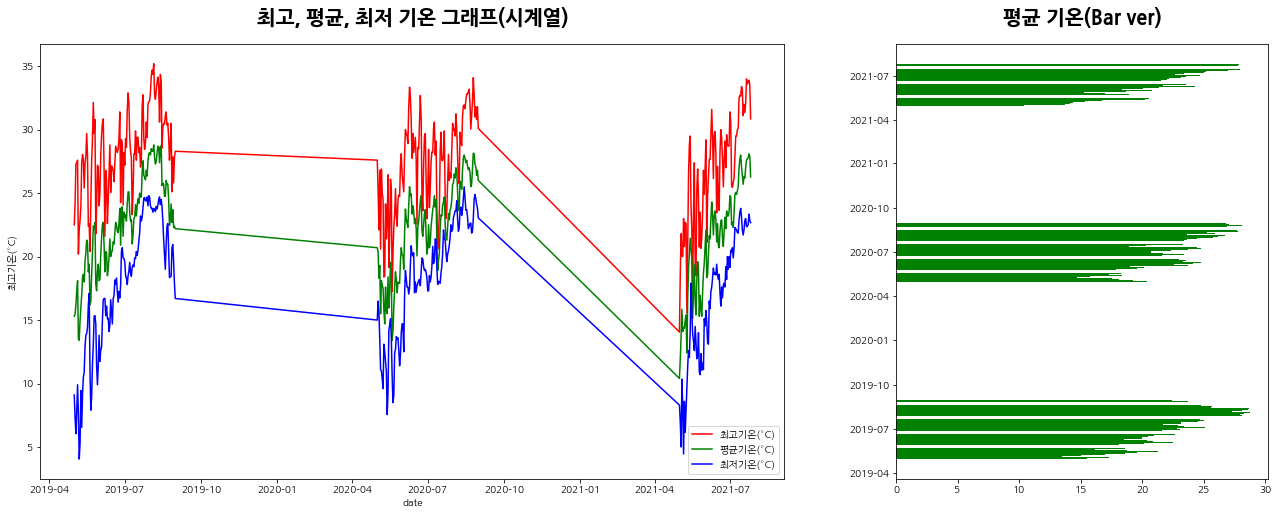

In [161]:
fig, ax = plt.subplots(1,2, figsize=(22,8), gridspec_kw={'width_ratios':[2, 1]})
sns.lineplot(x=data.groupby(['date'])['최고기온(°C)'].median().index, y=data.groupby(['date'])['최고기온(°C)'].median(), color='red', label='최고기온(°C)', ax=ax[0])
sns.lineplot(x=data.groupby(['date'])['평균기온(°C)'].median().index, y=data.groupby(['date'])['평균기온(°C)'].median(), color='green', label='평균기온(°C)', ax=ax[0])
sns.lineplot(x=data.groupby(['date'])['최저기온(°C)'].median().index, y=data.groupby(['date'])['최저기온(°C)'].median(), color='blue', label='최저기온(°C)', ax=ax[0])
ax[0].set_title('최고, 평균, 최저 기온 그래프(시계열)', fontsize=20, fontweight='bold', pad=20)

plt.barh(data.groupby(['date'])['평균기온(°C)'].median().index, data.groupby(['date'])['평균기온(°C)'].median(), color='green')
plt.title('평균 기온(Bar ver)', fontsize=20, fontweight='bold', pad=20)


In [248]:
data['월일'] = data['date'].astype('string').apply(lambda x: x[5:])

In [249]:
year_2019 = data.loc[data['year'] == 2019]
year_2020 = data.loc[data['year'] == 2020]
year_2021 = data.loc[data['year'] == 2021]

Text(0.5, 1.0, '연도별 최고기온(°C) 비교')

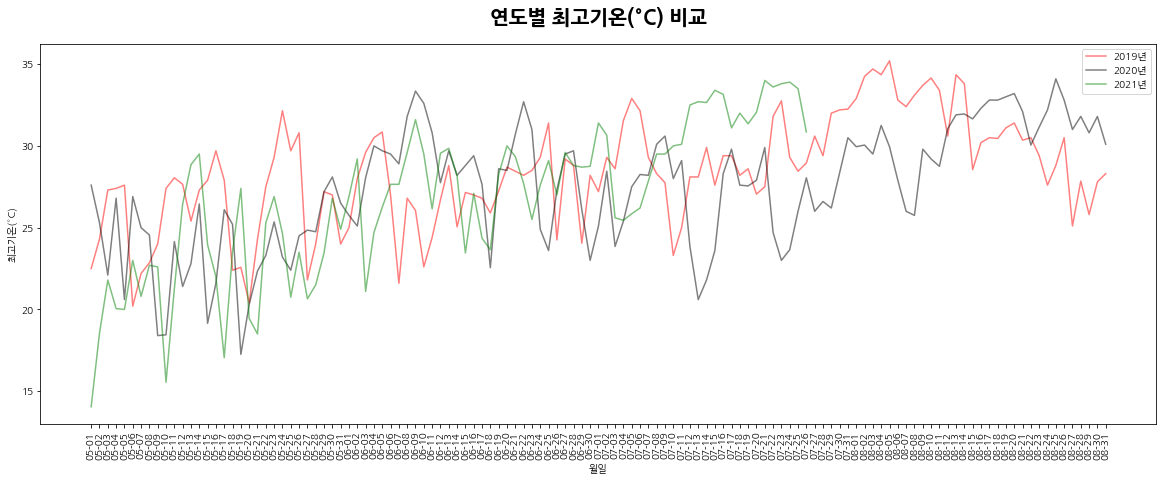

In [271]:
plt.subplots(figsize=(20, 7))
sns.lineplot(x=year_2019.groupby('월일')['최고기온(°C)'].median().index, y=year_2019.groupby('월일')['최고기온(°C)'].median(), color='red', label='2019년', alpha=0.5)
sns.lineplot(x=year_2020.groupby('월일')['최고기온(°C)'].median().index, y=year_2020.groupby('월일')['최고기온(°C)'].median(), color='black', label='2020년', alpha=0.5)
sns.lineplot(x=year_2021.groupby('월일')['최고기온(°C)'].median().index, y=year_2021.groupby('월일')['최고기온(°C)'].median(), color='green', label='2021년', alpha=0.5)

plt.xticks(rotation=90)
plt.title('연도별 최고기온(°C) 비교', fontsize=20, pad=20, fontweight='bold')

# To_do

# 1. 시계열 별로 최저, 평균 온도 비교 시각화 계속 하기

# 2. 지역별로 온도 비교하기

# 3. 기온과 습도를 가지고 상관관계 나타내기(scatter, heatmap, correlation)

# 4. 폭염여부 classification 하기


Text(0.5, 1.0, '연도별 최고기온(°C) 분포')

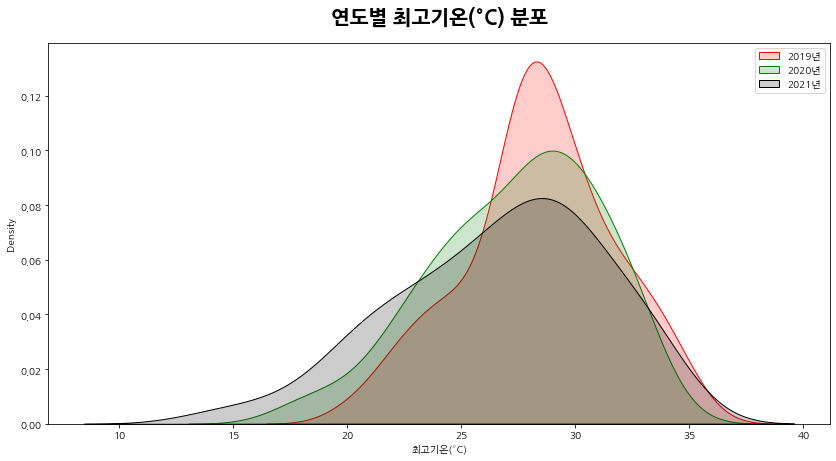

In [206]:
plt.subplots(figsize=(14, 7))
sns.kdeplot(year_2019.groupby('date')['최고기온(°C)'].median(), color='red', fill=True, label='2019년', alpha=0.2)
sns.kdeplot(year_2020.groupby('date')['최고기온(°C)'].median(), color='green', fill=True, label='2020년', alpha=0.2)
sns.kdeplot(year_2021.groupby('date')['최고기온(°C)'].median(), color='black', fill=True, label='2021년', alpha=0.2)
plt.legend()
plt.title('연도별 최고기온(°C) 분포', fontsize=20, pad=20, fontweight='bold')

# Vizualization 후 알 수 있는 것
 - 이 데이터는 5,6,7,8월 데이터만 있기 때문에 lineplot에서 없는 시계열이 이어지게 나타남

 - 2019년과 2021년의 4,5월 최저기온이 2020년 4,5월 최저기온 보다 낮다.
  - 하지만 최고기온은 2019년이 더 높다 ==> 결과적으로 최저기온은 낮지만 2019년이 2020년보다 더웠다.(강우라는 외부요인 때문 일수도 있다.)

 - 2021년은 이미 7월부터 2018년 이후 최고기온을 찍고 있다. 

In [ ]:
data['폭염영향예보(단계)'] = data['폭염영향예보(단계)'].replace(' ', '평시')
data['폭염영향예보(단계)'].value_counts()

평시    38913
관심     6223
주의     5717
경고     3082
심각       11
Name: 폭염영향예보(단계), dtype: int64